# Deep Mario with Random Forest
Actualizado al 25/Nov con 35 columns

In [169]:
import numpy as np
import pandas as pd
import networkx as nx
import collections 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 


1.0.1


In [170]:
df = pd.read_csv("../results/results_BarabasiFog_X/samples.csv")
print(len(df))
print(len(df.columns))

40030
35


In [171]:
#dummies
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]

actions = np.arange(len(actions_labels)) #dummies
df["Action"] = df["Action"].map(lambda x:actions_labels.index(x))
df["CurrentFlavour"] = df["CurrentFlavour"].map(lambda x:actions_labels.index(x))

In [172]:
df.head()

,Sim,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,...,NextAvgRequests,NextSumLat,NextAvgLat,DstHWTotal,NextHWUsed,NextUtilization,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,0,6,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,0,1.0
1,0,0,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,0,0.0
2,0,1,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,6.0,4,0.333333,5,0.384615,0,0.0
3,0,2,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,0,0.0
4,0,3,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,2.0,1,0.500000,1,0.076923,0,0.0


In [173]:
# UNIT TESTs
# El reward positivo de una Action-undeploy no puede realizarse si hay peticiones futuras
assert len(df.loc[(df["Action"]==6) & (df["Reward"]==1) & (df["NextSumRequests"]>0)])==0

# No puede haber ninguna acción diferente al undeploy con reward positivo si no recibe peticiones
assert len(df.loc[(df["Action"]!=6) & (df["SumRequests"]==0) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de migración positiva cuando hay más de un canal
assert len(df.loc[(df["Action"]==1) & (df["DifReqChannels"]>1) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de replicación positiva cuando hay solo un canal
assert len(df.loc[(df["Action"]==0) & (df["DifReqChannels"]==1) & (df["Reward"]>0)])==0

In [174]:
df = df.drop(columns="Sim") # debug columns

In [175]:
print(list(df.columns))

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'NextSupportedRequests', 'NextHWReq', 'NextDifReqChannels', 'NextTotReqChannels', 'NextSumRequests', 'NextAvgRequests', 'NextSumLat', 'NextAvgLat', 'DstHWTotal', 'NextHWUsed', 'NextUtilization', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [176]:
# Our state is based on a set of columns
# We can remove columns with NEXT* name
state_cols = [x for x in df.columns if "Next" not in x]
print(state_cols)

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [177]:
df = df.loc[:,state_cols]
df.head()

,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,6,1,4,10,2,0,0,0,0.0,0,...,1,0.076923,0,0,0.0,2.0,1,0.076923,0,1.0
1,0,1,4,10,2,0,0,0,0.0,0,...,1,0.076923,0,0,0.0,2.0,1,0.076923,0,0.0
2,1,1,4,10,2,0,0,0,0.0,0,...,1,0.076923,0,0,0.0,6.0,5,0.384615,0,0.0
3,2,1,4,10,2,0,0,0,0.0,0,...,1,0.076923,0,0,0.0,2.0,1,0.076923,0,0.0
4,3,1,4,10,2,0,0,0,0.0,0,...,1,0.076923,0,0,0.0,2.0,1,0.076923,0,0.0


In [185]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "Reward"),
                                        df['Reward'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))
print(len(y_test))

30022
10008
10008


In [179]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [180]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "Reward").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
0,Action,0.385452
6,TotReqChannels,0.150368
7,SumRequests,0.144072
5,DifReqChannels,0.116446
8,AvgRequests,0.055690
3,SupportedRequests,0.039766
1,App,0.027872
12,HWUsed,0.023749
4,HWReq,0.011443
13,Utilization,0.010321


In [181]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.471708,0.002761,Action
7,0.167221,0.000712,SumRequests
3,0.108015,0.001383,SupportedRequests
6,0.106751,0.000560,TotReqChannels
5,0.099143,0.001583,DifReqChannels
1,0.083842,0.000632,App
12,0.073014,0.001607,HWUsed
8,0.067709,0.000445,AvgRequests
4,0.046429,0.000616,HWReq
13,0.036648,0.000838,Utilization


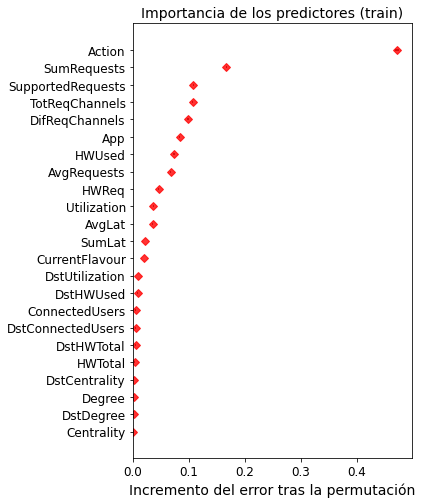

In [182]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# Evaluation 

In [188]:
from sklearn import metrics
y_pred = model.predict(X_test)
#X_train, X_test, y_train, y_test
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.011602217580935253
Mean Squared Error: 0.004886039685307495
Root Mean Squared Error: 0.0699002123409328


## TESTING

In [43]:
dtest = df.loc[y_test.index]
dtest.head()

,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers,Reward
31457,2,1,3,5,1,0,0,0,0.0,0,...,1,0.076923,0,0,0.000000,4.0,1,0.076923,0,0.000000
31067,2,1,3,5,1,1,1,5,5.0,2,...,1,0.076923,1,0,0.000000,2.0,1,0.076923,1,0.500000
39697,4,2,5,30,3,1,1,1,1.0,12,...,4,0.307692,0,1,0.166667,6.0,4,0.307692,0,0.666667
7660,6,3,4,20,4,1,1,2,2.0,0,...,1,0.076923,1,0,0.000000,4.0,1,0.076923,1,0.000000
23074,6,2,3,2,1,0,0,0,0.0,0,...,1,0.076923,0,0,0.000000,2.0,1,0.076923,0,1.000000


In [45]:
from collections import Counter
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
actions_rcat = range(len(actions_labels))
acts = collections.defaultdict(list)
col = df.columns[:-1]
f = open("results_RF.csv","w")
for act_ix,act in enumerate(actions_labels):
    dt = dtest.loc[(dtest["Action"]==act_ix) & (dtest["Reward"]>0)]
    print("Action,%s,%i"%(act,len(dt)))
    f.write("Action,%s,%i\n"%(act,len(dt)))
    counter = Counter()
    for e,(ix,row) in enumerate(dt.iterrows()):
        vals = []
        for i in actions_rcat:
            dftest = pd.DataFrame(columns=list(col))
            row["Action"] = i
            dftest.loc[0]= row
            forecasting = model.predict(X = dftest)
            vals.append(forecasting[0])

        ix_max = np.argmax(vals)
        
        
        counter[actions_labels[ix_max]]+=1
#        if e == 2:
#            break
    for (action,v) in counter.items():
        print("%s,%i,%0.4f"%(action,v,v/float(len(dt))))
        f.write("%s,%i,%0.4f\n"%(action,v,v/float(len(dt))))

f.close()

Action,replicate,70
replicate,61,0.8714
large,8,0.1143
medium,1,0.0143
Action,migrate,0
Action,none,474
none,204,0.4304
small,94,0.1983
medium,153,0.3228
large,23,0.0485
Action,small,156
small,129,0.8269
none,4,0.0256
medium,14,0.0897
large,3,0.0192
replicate,6,0.0385
Action,medium,193
small,72,0.3731
medium,90,0.4663
none,9,0.0466
replicate,15,0.0777
large,7,0.0363
Action,large,145
replicate,35,0.2414
large,48,0.3310
small,33,0.2276
medium,24,0.1655
none,5,0.0345
Action,undeploy,1081
undeploy,1081,1.0000


In [74]:
from collections import defaultdict
import copy
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
path_res = "results_RF.csv"
vals = defaultdict(list)
res = pd.read_csv(path_res,header=None)
first = False
actions_no_used = copy.copy(actions_labels)
for i,r in res.iterrows():
    if r[0]=="Action":
        if first:
            for action in actions_no_used:
                vals[action].append(0)
            actions_no_used = copy.copy(actions_labels)
        ix = actions_labels.index(r[1])        
        rate = r[2]
        first = True
    else:
        action = r[0]
        perc = r[2]
        vals[action].append(perc)
        actions_no_used.remove(action)
for action in actions_no_used:
    vals[action].append(0)
print(vals)

defaultdict(<class 'list'>, {'replicate': [0.8714, 0, 0, 0.0385, 0.0777, 0.2414, 0], 'large': [0.1143, 0, 0.0485, 0.0192, 0.0363, 0.331, 0], 'medium': [0.0143, 0, 0.3228, 0.0897, 0.4663, 0.1655, 0], 'migrate': [0, 0, 0, 0, 0, 0, 0], 'none': [0, 0, 0.4304, 0.0256, 0.0466, 0.0345, 0], 'small': [0, 0, 0.1983, 0.8269, 0.3731, 0.2276, 0], 'undeploy': [0, 0, 0, 0, 0, 0, 1.0]})


/var/folders/hd/b3xdbhj91fj7d7_gq2f0v1h40000gn/T/ipykernel_8861/2617418353.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, size=12)


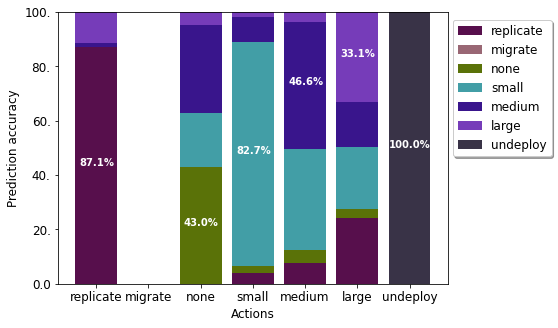

In [166]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

font_size = 12
font_size_ax = 14
plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size) 
plt.rc('axes', titlesize=font_size_ax)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_ax) 

colors_list = ["#570f4c","#996774","#5A7208","#429ea6","#39158c","#763CB9","#393347"]
# create data
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
acc = np.zeros(len(actions_labels))
fig, ax = plt.subplots(figsize=(7,5))

for ix,action in enumerate(actions_labels):
    y = np.array(vals[action])
    rects = plt.bar(actions_labels, y,bottom=acc, color=colors_list[ix])
    rect = rects[ix]
    k = 10.0
    if len("%2.1f%%"%(y[ix]*100.0))>5: k = 80.0
    ax.text(rect.get_x()+rect.get_width()/k, acc[ix]+rect.get_height()/2.,
                "%2.1f%%"%(y[ix]*100.0), rotation=0,color="white",weight="bold")
    acc += y
yticks = ax.get_yticks()
yticks = ["0.","20.", "40.", "60.", "80.", "100."]
ax.set_yticklabels(yticks, size=12)
plt.xlabel("Actions", size=12)
plt.ylabel("Prediction accuracy (%)", size=12)
plt.legend(actions_labels,loc='center right', bbox_to_anchor=(1.28, 0.72),
          fancybox=True, shadow=True, ncol=1)
plt.show()
fig.savefig("randomForestByAction.pdf", dpi=400, bbox_inches='tight')